In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
%matplotlib inline

from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from scipy.stats import randint

<H2 align="center"> Pre-Processing </H2>

In [3]:
# Read in Data
data = pd.read_csv('../data/model_data/spatial_df/Lassa_spatialdataset_201219separateyears_labconfirmed.csv')
data.replace('',np.nan,regex = True)
data.dropna(inplace=True)

# Separate data so that we train the model on 2012-2017 data
# and test it's predictive ability against 2018-2019 data
df18 = data[(data['Year'] == 2018)].copy()
df19 = data[(data['Year'] == 2019)].copy()



# Creating LGA names set and then assigning them their indices as values
lga_names = set(data['LGA'])
lga_replace_dict = {value: i for i, value in enumerate(lga_names)}

# Creating Year names set and then assigning them their indices as values
year_names = set(data['Year'])
year_replace_dict = {value: i for i, value in enumerate(year_names)}

# Creating Admin names set and then assigning them their indices as values
administration_names = set(data['admin1Name'])
administration_replace_dict = {value: i for i, value in enumerate(administration_names)}

# Creating Source names set and then assigning them their indices as values
source_names = set(data['Source'])
source_replace_dict = {value: i for i, value in enumerate(source_names)}


# Replaces string values for integer values in dataset
data = data.replace({'LGA':lga_replace_dict, 
                      'Year': year_replace_dict,
                      'admin1Name': administration_replace_dict,
                      'Source': source_replace_dict})

df18 = df18.replace({'LGA':lga_replace_dict, 
                      'Year': year_replace_dict,
                      'admin1Name': administration_replace_dict,
                      'Source': source_replace_dict})

df19 = df19.replace({'LGA':lga_replace_dict, 
                      'Year': year_replace_dict,
                      'admin1Name': administration_replace_dict,
                      'Source': source_replace_dict})


# Features in the dataset that were already normalized or dont need normalizing
ignore_norm_cols_array = ["AgriProp_ESA", "UrbanProp_ESA", "ForestProp_ESA", "TempMonthlyCoefv_201118_NOAA",
                     "TotalPop2015_PropUrban", "ImprovedHousingPrev_PopWeighted", "Cropland_prop_ESA2015",
                     "Agri_prop_ESA2015", "Urb_prop_ESA2015", "Forest_prop_ESA2015", "PovertyProp_Mean",
                     "PovertyProp_PopWeighted", "LGA", "Year", "admin1Name", "Source"]

# Normalize the data
# FOR NOW: DO NOT NORMALIZE DF18 & DF19
# RUNNING INTO PROBLEMS WITH NUMDIAGCENTRES 
# (AND OTHER FEATURES?) THAT HAVE ONLY 1 UNIQUE VALUE
for heading in data.columns:  
  if heading not in ignore_norm_cols_array:
    data[heading] = ( data[heading] - ( min(data[heading]) ) ) / ( max(data[heading]) - min(data[heading]) )
    #df18[heading] = ( df18[heading] - ( min(df18[heading]) ) ) / ( max(df18[heading]) - min(df18[heading]) )
    #df19[heading] = ( df19[heading] - ( min(df19[heading]) ) ) / ( max(df19[heading]) - min(df19[heading]) )


# Remove these columns
data = data.loc[:, ~data.columns.isin(['Cases', 'Cases_SuspectedUnconfirmed', 'Year', 'Source', 'x', 'y', 'Reports_All'])]
df18 = df18.loc[:, ~df18.columns.isin(['Cases', 'Cases_SuspectedUnconfirmed', 'Year', 'Source', 'x', 'y', 'Reports_All'])].copy()
df19 = df19.loc[:, ~df19.columns.isin(['Cases', 'Cases_SuspectedUnconfirmed', 'Year', 'Source', 'x', 'y', 'Reports_All'])].copy()


# Set target variable as only the confirmed cases of LF; 'Any_Confirmed_Cases' is a binary class
x = data.iloc[:, data.columns != 'Any_Confirmed_Cases']
y = data.iloc[:, data.columns == 'Any_Confirmed_Cases']

# Set target variable for 2018 & 2019 dataset
x18 = df18.iloc[:, df18.columns != 'Any_Confirmed_Cases']
y18 = df18.iloc[:, df18.columns == 'Any_Confirmed_Cases']

x19 = df19.iloc[:, df19.columns != 'Any_Confirmed_Cases']
y19 = df19.iloc[:, df19.columns == 'Any_Confirmed_Cases']

# Retype from float to int
y = y.astype(int)
y18 = y18.astype(int)
y19 = y19.astype(int)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

<H2 align="center"> Hyperparameter Tuning </H2>

In [4]:
# TODO: [] Add more hyperparameters to the param_grid
#       [] Learning should become some sort of randfloat

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier

param_grid = {  'max_depth': [4,6,8],
                'n_estimators': [100, 200, 300],
                'learning_rate': [0.1, 0.01, 0.001]
            }

# LEARNING RATE SHOULD NOT BE RANDINT, SHOULD BE SOME SORT OF RANDFLOAT
param_dist = {'n_estimators': randint(100, 500),
              'max_depth': randint(1,20),
              'learning_rate': randint(0.001, 0.11)}

model = XGBClassifier(objective='binary:logistic')

rando_cv = RandomizedSearchCV(model, param_grid, cv=5, n_iter=10)
rando_cv.fit(x_train, y_train)
rando_params = rando_cv.best_params_
best_rando = rando_cv.best_estimator_

grid_cv = GridSearchCV(model, param_grid=param_grid, cv=5)
grid_cv.fit(x_train, y_train)
grid_params = grid_cv.best_params_
best_grid = grid_cv.best_estimator_


print(best_rando.score(x_test, y_test))
print(best_grid.score(x_test, y_test))

0.962532299741602
0.962532299741602


<H2 align="center"> Model Evaluation</H2>

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

best_model = best_grid

# Make predictions
y_pred = best_model.predict(x_test)
y18_pred = best_model.predict(x18)
y19_pred = best_model.predict(x19)

# Create Confusion Matrices
cfMatrix = confusion_matrix(y_test, y_pred)
cfMatrix18 = confusion_matrix(y18, y18_pred)
cfMatrix19 = confusion_matrix(y19, y19_pred)


# Create F1 and Accuracy Scores
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1_18 = f1_score(y18, y18_pred)
accuracy_18 = accuracy_score(y18, y18_pred)
f1_19 = f1_score(y19, y19_pred)
accuracy_19 = accuracy_score(y19, y19_pred)


# Create Cross Validation Scores
scores = cross_val_score(best_model, x_train, y_train, cv=10)


# Create classification reports
cr = classification_report(y_pred, y_test)
cr18 = classification_report(y18_pred, y18)
cr19 = classification_report(y19_pred, y19)

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


<H2 align="center"> Results </H2>

2012-2017 Data
F1 Score: 0.49122807017543857
Accuracy: 0.962532299741602

2018 Data
F1 Score: 0.0
Accuracy: 0.8850129198966409

2019 Data
F1 Score: 0.0
Accuracy: 0.8837209302325582
Mean score: 0.950477845754542
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1510
           1       0.37      0.74      0.49        38

    accuracy                           0.96      1548
   macro avg       0.68      0.85      0.74      1548
weighted avg       0.98      0.96      0.97      1548

              precision    recall  f1-score   support

           0       1.00      0.89      0.94       774
           1       0.00      0.00      0.00         0

    accuracy                           0.89       774
   macro avg       0.50      0.44      0.47       774
weighted avg       1.00      0.89      0.94       774

              precision    recall  f1-score   support

           0       1.00      0.88      0.94       774
           1       0.00   

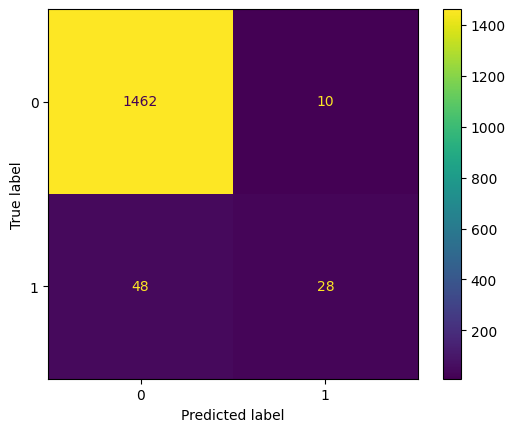

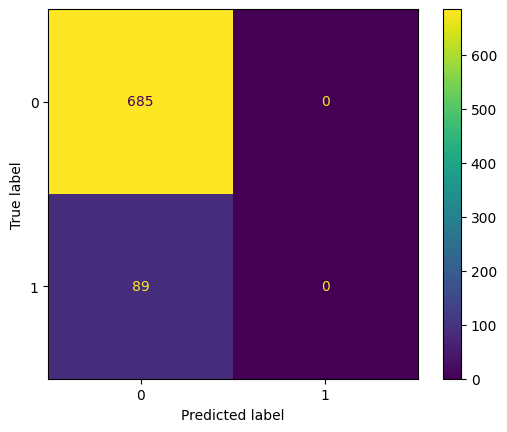

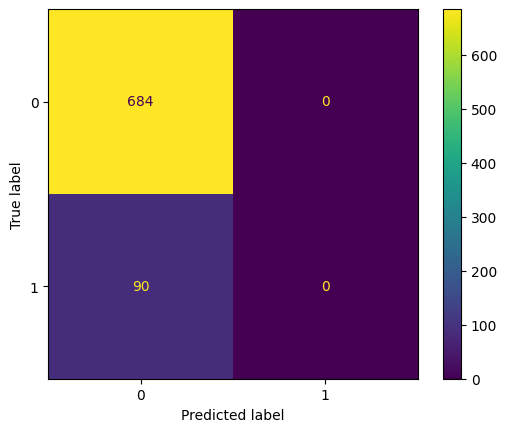

In [6]:
#print(f"2012-2017 Data\n {cfMatrix} \n\n 2018 Data\n {cfMatrix18} \n\n 2019 Data\n {cfMatrix19}")
ConfusionMatrixDisplay(confusion_matrix=cfMatrix).plot()
ConfusionMatrixDisplay(confusion_matrix=cfMatrix18).plot()
ConfusionMatrixDisplay(confusion_matrix=cfMatrix19).plot()

print(f"2012-2017 Data\nF1 Score: {f1}\nAccuracy: {accuracy}\n\n2018 Data\nF1 Score: {f1_18}\nAccuracy: {accuracy_18}\n\n2019 Data\nF1 Score: {f1_19}\nAccuracy: {accuracy_19}")

print(f"Mean score: {scores.mean()}")

print(f"{cr}\n{cr18}\n{cr19}")

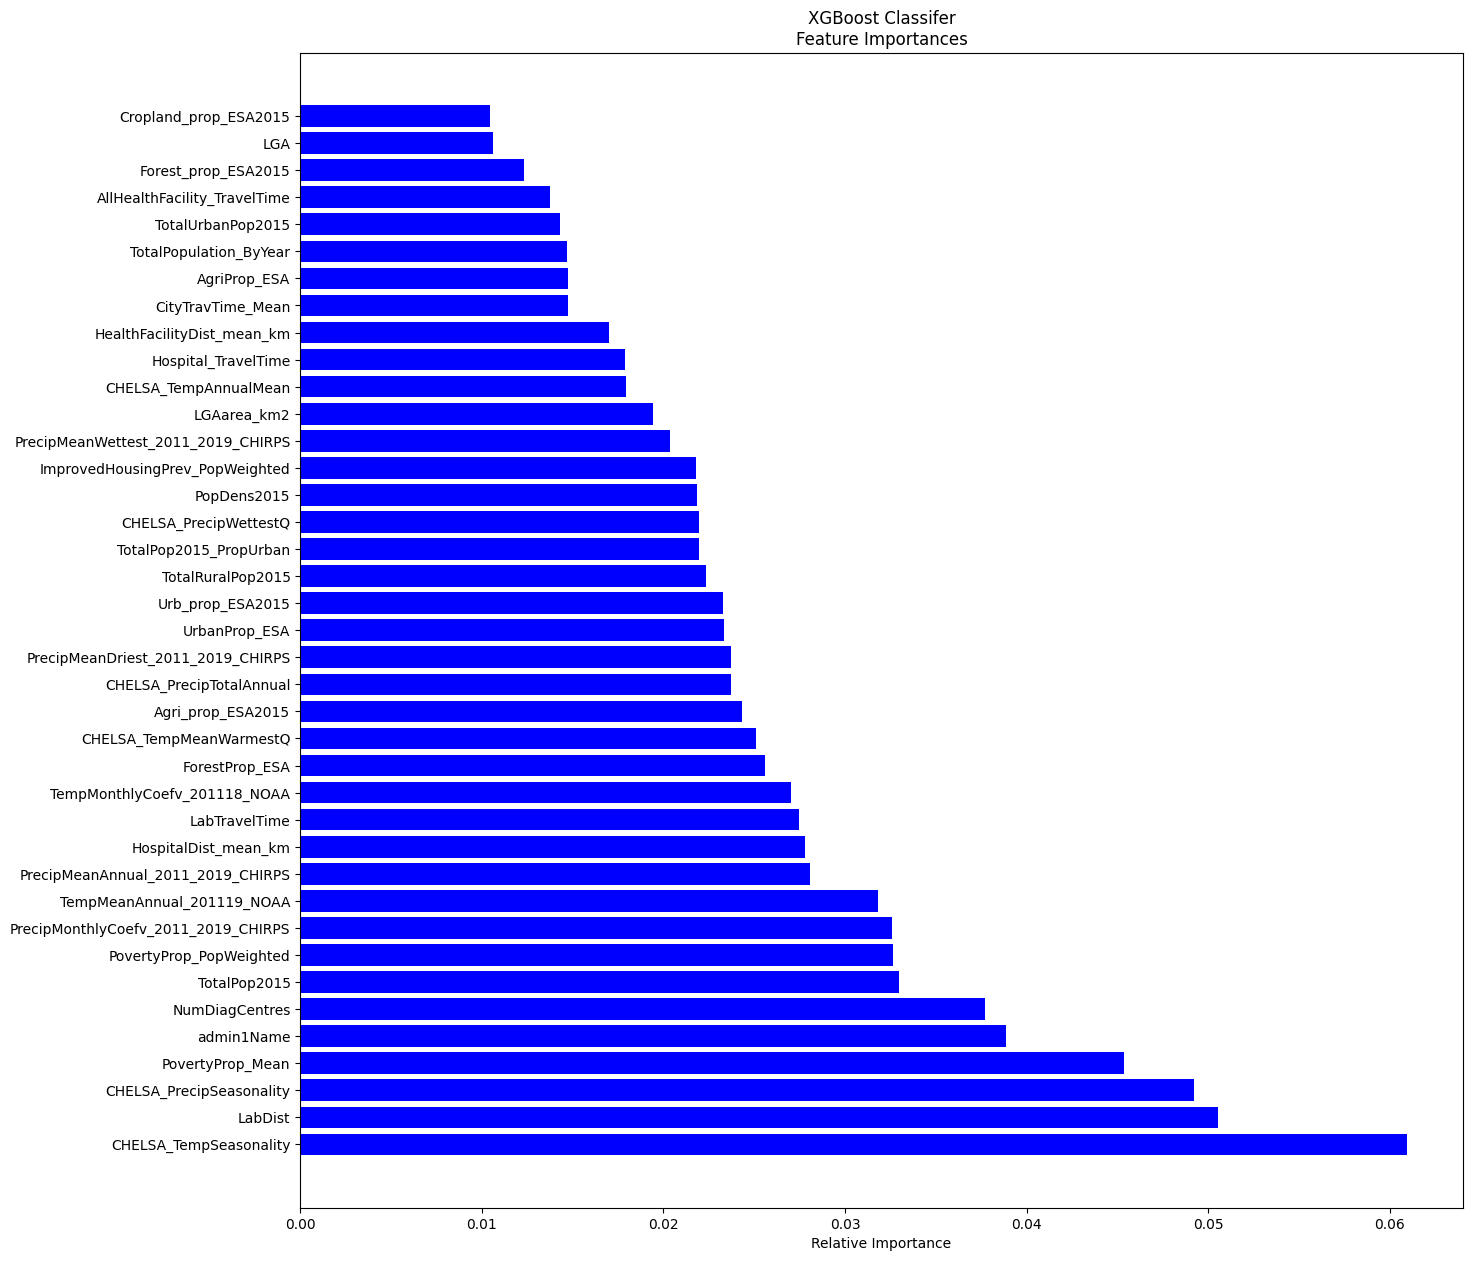

In [8]:
features = x_test.columns
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

fig, ax = plt.subplots(figsize=(15,15))

ax.set_title("XGBoost Classifer\nFeature Importances")
ax.barh(range(len(indices)), importances[indices], color='b', align='center')
ax.set_yticks(range(len(indices)), [features[i] for i in indices])
ax.set_xlabel('Relative Importance')
plt.show()

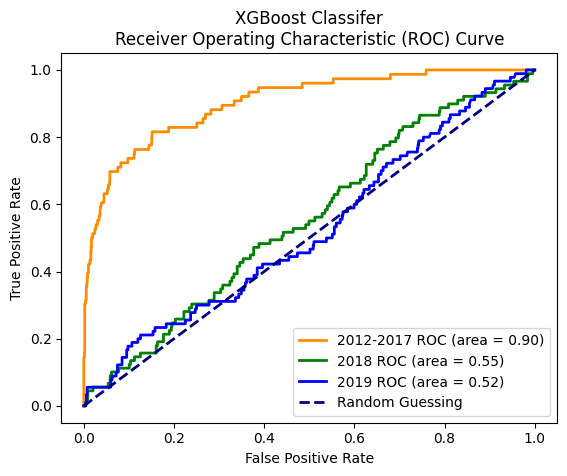

In [9]:
from sklearn.metrics import roc_curve, auc

fig, ax = plt.subplots()

# AUC / ROC for 2012-2017
y_score = best_model.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, color='darkorange', lw=2,label='2012-2017 ROC (area = %0.2f)' % roc_auc)

# AUC / ROC for 2018
y18_score = best_model.predict_proba(x18)[:, 1]
fpr, tpr, thresholds = roc_curve(y18, y18_score)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, color='green', lw=2,label='2018 ROC (area = %0.2f)' % roc_auc)

# AUC / ROC for 2019
y19_score = best_model.predict_proba(x19)[:, 1]
fpr, tpr, thresholds = roc_curve(y19, y19_score)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, color='blue', lw=2,label='2019 ROC (area = %0.2f)' % roc_auc)

# Random guessing
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')

# Labels, title, and legend
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('XGBoost Classifer\nReceiver Operating Characteristic (ROC) Curve')
ax.legend(loc="lower right")

plt.show()

<H2 align="center"> SHAP Analysis </H2>

In [20]:
explainer = shap.TreeExplainer(best_model, x_test)
shap_values = explainer(x_test)

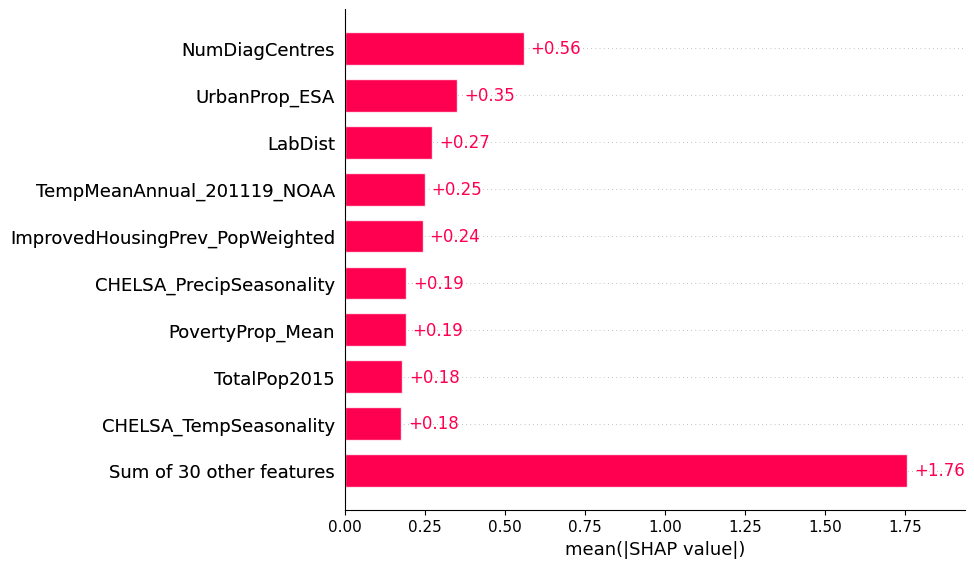

In [21]:
# Global Bar Plot
shap.plots.bar(shap_values, max_display=10)

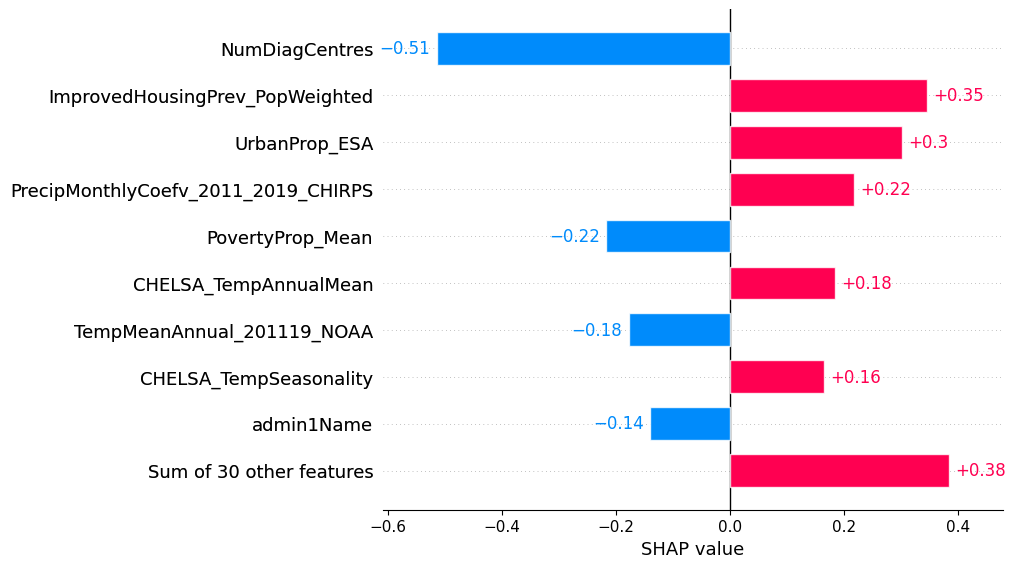

In [22]:
# Local Bar Plot
shap.plots.bar(shap_values[0])

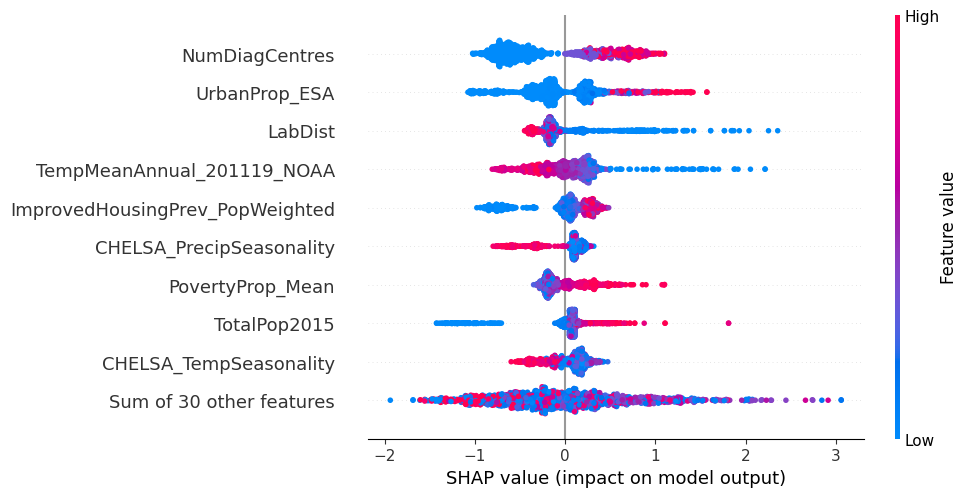

In [23]:
shap.plots.beeswarm(shap_values, max_display=10)

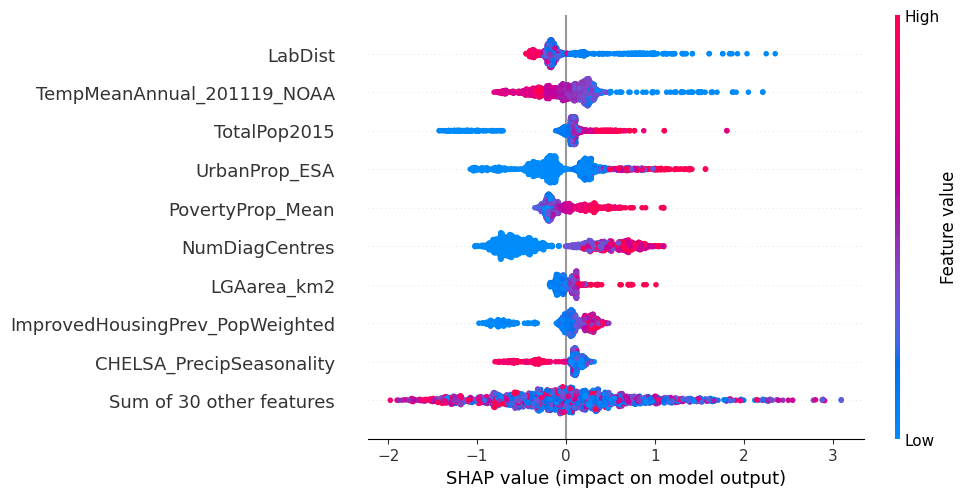

In [24]:
# Order features by abs.max instead of default abs.mean
shap.plots.beeswarm(shap_values, max_display=10, order=shap_values.abs.max(0))

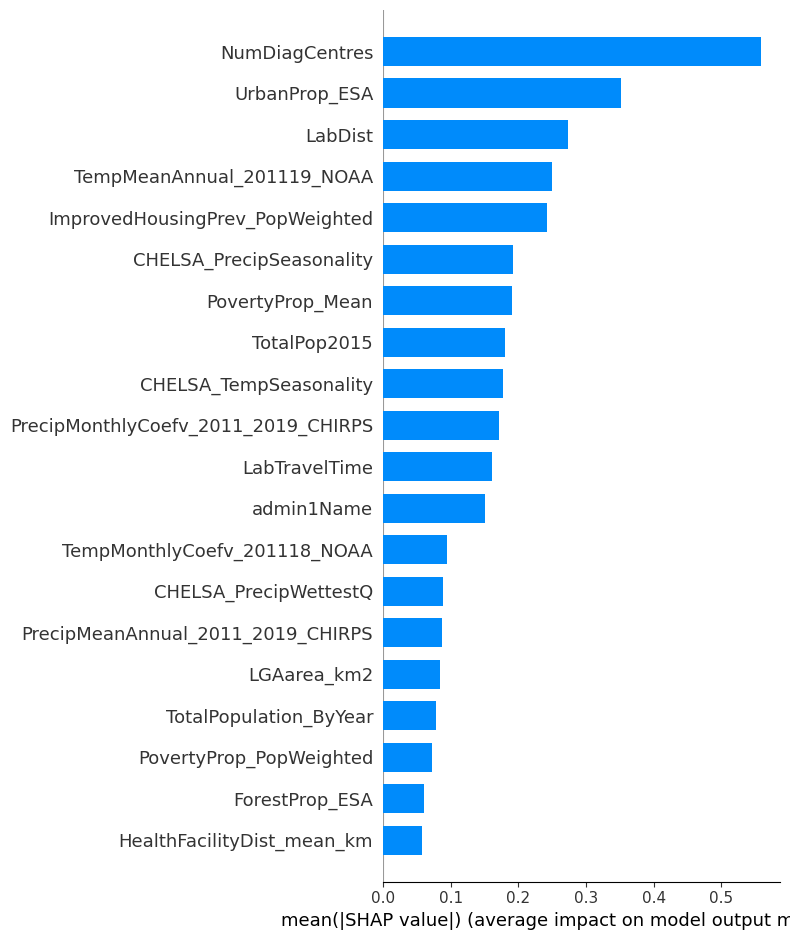

In [25]:
shap.summary_plot(shap_values, x_test, plot_type='bar')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


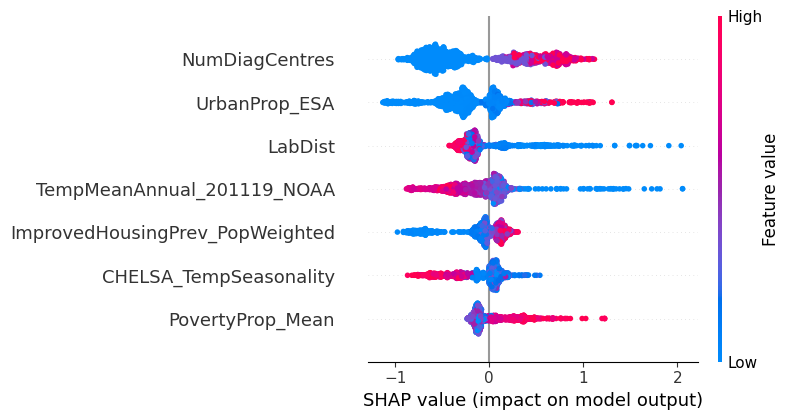

In [16]:
shap.summary_plot(shap_values, x_test, max_display=7, plot_type='dot')

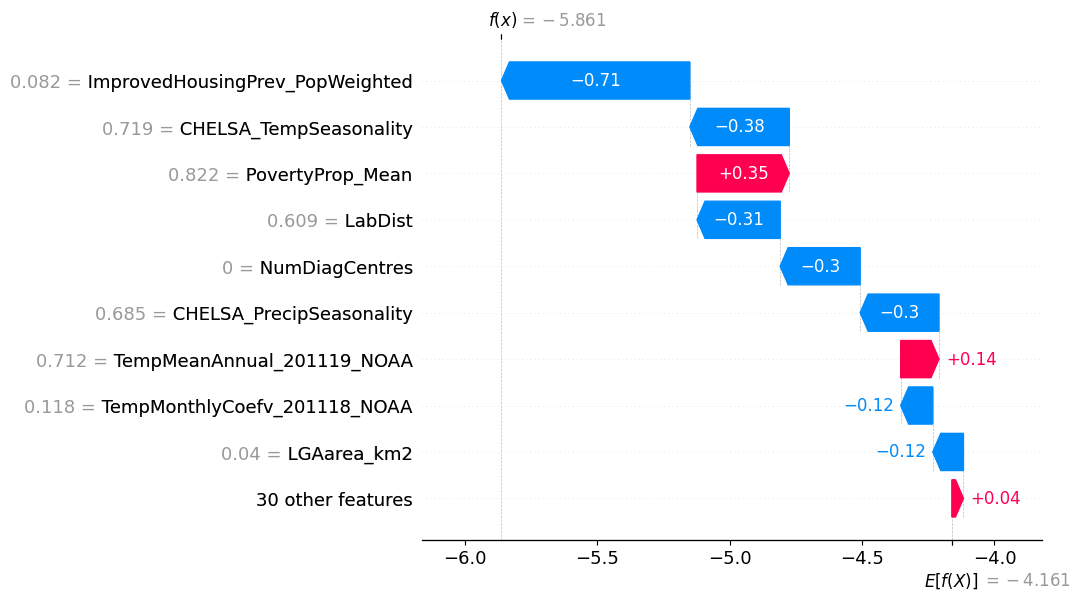

In [18]:
shap.plots.waterfall(shap_values[0])